# Areios Pagos Decision Analysis: Extraction and Visualization



This notebook performs two main tasks:
1.  **Data Extraction:** It scrapes legal decision metadata and cited articles from the Areios Pagos (Supreme Court of Greece) website for specified sectors and years.
2.  **Data Analysis & Visualization:** It loads the extracted data, cleans it, and generates various plots to explore trends, distributions, and patterns in the decisions.

## 1. Setup and Imports

First, we import all the necessary libraries for web scraping, data manipulation, and plotting. We also configure warnings to keep the output clean.

In [47]:
import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Configuration

Helper function to extract the needed data from a given decision.

In [48]:
def extract_decision_data(soup):
    """
    Extracts specific data points from the BeautifulSoup object of a decision page.
    """
    data = {
        "judges": None,
        "court_intro_text": None,
        "reasoning_text": None,
        "decision_text": None,
        "articles_ak": set(),      # Use sets to store unique articles
        "articles_kpolΔ": set(),
        "articles_pk": set(),
        "articles_kpd": set(),
    }

    try:
        # The <font face="Arial" size="3"> tag seems to contain the main legal text
        content_font = soup.find('font', {'face': 'Arial', 'size': '3'})
        if not content_font:
            print("Warning: Main content font tag not found.")
            return data # Return empty data if content not found

        # Get text with line breaks preserved, important for finding specific lines/paragraphs
        # Using '\n' as separator helps split later. Strip removes leading/trailing whitespace from the whole block.
        full_text = content_font.get_text(separator='\n', strip=True)
        lines = full_text.split('\n') # Split into lines for easier processing

        # --- Extract Judges ---
        judges_prefix = "Συγκροτήθηκε από τους δικαστές"
        for line in lines:
            clean_line = line.strip()
            if clean_line.startswith(judges_prefix):
                data["judges"] = clean_line
                break # Found it, no need to check further

        # --- Extract Text Blocks using Markers ---
        marker1 = "ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ"
        marker2 = "ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ"
        marker3 = "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ"

        try:
            # Find indices of markers in the full text
            start_intro = full_text.find(marker1)
            start_reasoning = full_text.find(marker2)
            start_decision = full_text.find(marker3)

            if start_intro != -1 and start_reasoning != -1:
                 # Extract text between marker1 and marker2
                 # Strip leading/trailing whitespace from the extracted block
                data["court_intro_text"] = full_text[start_intro:start_reasoning].strip()

            if start_reasoning != -1 and start_decision != -1:
                # Extract text between marker2 and marker3
                data["reasoning_text"] = full_text[start_reasoning:start_decision].strip()

            if start_decision != -1:
                 # Extract text from marker3 to the end (or a suitable end point if needed)
                 # Let's find the end marker like "ΚΡΙΘΗΚΕ" or similar if "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ" isn't the absolute end.
                 # For now, taking text until "ΚΡΙΘΗΚΕ" seems reasonable based on the example.
                 end_decision_marker = "ΚΡΙΘΗΚΕ,"
                 end_decision = full_text.find(end_decision_marker, start_decision)
                 if end_decision != -1:
                     data["decision_text"] = full_text[start_decision:end_decision].strip()
                 else:
                     # Fallback: take text from marker3 onwards if end marker not found
                     data["decision_text"] = full_text[start_decision:].strip()

        except Exception as e:
            print(f"Error extracting text blocks: {e}")


        # --- Extract Articles using Regex ---
        # We'll search primarily in the reasoning and decision text, as they contain the legal basis
        search_text = (data.get("reasoning_text") or "") + "\n" + (data.get("decision_text") or "")

        # Define regex patterns for each code - more robust patterns
        # Pattern format: (Code Name) (Article Num) [Optional: (Specifier) (Specifier Num/Letter)]
        # Or: (Article Num) (Specifier like 'του') (Code Name) [Optional: (Specifier) (Specifier Num/Letter)]
        patterns = {
            "articles_kpolΔ": r'(?:(ΚΠολΔ|Κ\.Πολ\.Δ)\.?\s+(\d+)|(\d+)\s+(?:του\s+)?(?:ΚΠολΔ|Κ\.Πολ\.Δ))(?:\s+(παρ|αριθμ|αρ|εδ|στοιχ)\.?)?\s*(\d+|[α-ζΑ-Ω]+)?',
            "articles_ak":    r'(?:(ΑΚ|Α\.Κ)\.?\s+(\d+)|(\d+)\s+(?:του\s+)?(?:ΑΚ|Α\.Κ))(?:\s+(παρ|αριθμ|αρ|εδ|στοιχ)\.?)?\s*(\d+|[α-ζΑ-Ω]+)?',
            "articles_pk":    r'(?:(ΠΚ|Π\.Κ)\.?\s+(\d+)|(\d+)\s+(?:του\s+)?(?:ΠΚ|Π\.Κ))(?:\s+(παρ|αριθμ|αρ|εδ|στοιχ)\.?)?\s*(\d+|[α-ζΑ-Ω]+)?',
            "articles_kpd":   r'(?:(ΚΠΔ|Κ\.Π\.Δ)\.?\s+(\d+)|(\d+)\s+(?:του\s+)?(?:ΚΠΔ|Κ\.Π\.Δ))(?:\s+(παρ|αριθμ|αρ|εδ|στοιχ)\.?)?\s*(\d+|[α-ζΑ-Ω]+)?',
            # Generic pattern for "άρθρο X" which might not specify the code nearby
            # We won't categorize these unless context implies it, but could be extracted separately if needed
            # "generic_articles": r'(?:άρθρ[οουων]+\.?|αρ\.)\s+(\d+)(?:\s+(παρ|αριθμ|αρ|εδ|στοιχ)\.?)?\s*(\d+|[α-ζΑ-Ω]+)?'
        }

        for key, pattern in patterns.items():
            # Use finditer to get match objects, which helps avoid overlapping matches if patterns are complex
            for match in re.finditer(pattern, search_text, re.IGNORECASE):
                # Determine article number (it's either group 2 or 3 based on pattern structure)
                article_num = match.group(2) or match.group(3)
                # Specifier (group 4) and its value (group 5) are optional
                specifier = match.group(4)
                specifier_val = match.group(5)

                if article_num: # Ensure we found an article number
                    formatted_article = str(article_num)
                    if specifier:
                        # Clean specifier (remove trailing dot if present)
                        clean_specifier = specifier.rstrip('.')
                        formatted_article += f" {clean_specifier}"
                        if specifier_val:
                            formatted_article += f" {specifier_val}"
                    # Add the unique formatted article string to the correct set
                    data[key].add(formatted_article.strip())

    except Exception as e:
        print(f"Error processing decision details: {e}")
        # Optionally re-raise or log the error more formally

    # Convert sets back to lists for easier JSON serialization if needed later
    data["articles_ak"] = sorted(list(data["articles_ak"]))
    data["articles_kpolΔ"] = sorted(list(data["articles_kpolΔ"]))
    data["articles_pk"] = sorted(list(data["articles_pk"]))
    data["articles_kpd"] = sorted(list(data["articles_kpd"]))

    return data

## 3. Data Extraction (Web Scraping)

This section contains the functions responsible for fetching and parsing data from the Areios Pagos website.

### 3.1 Helper Function: Extract Data from Decision Page

This function takes the HTML content (as a BeautifulSoup object) of a single decision page and extracts relevant details like judges, text blocks, and cited articles using **regular expressions**.

In [49]:
base_url = "https://areiospagos.gr/nomologia/"
def crawl_for_sector(sector: str, year: str):

  # We use a Session object to handle cookies automatically
  session = requests.Session()

  url = base_url + "apofaseis_result.asp?S=1"

  # Headers copied from the 'Network' tab of the browser
  headers = {
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
      # 'accept-encoding': 'gzip, deflate, br, zstd', # Let requests handle encoding negotiation
      'accept-language': 'en-US,en;q=0.9',
      'cache-control': 'max-age=0',
      # 'connection': 'keep-alive', # Let requests/session handle connection persistence
      'content-type': 'application/x-www-form-urlencoded',
      # Initial cookie value (good fallback, but session should handle it after GET)
      # 'cookie': 'perf_dv6Tr4n=1; _ga=GA1.2.64080178.1744405713; _gid=GA1.2.1669692749.1744405713; ASPSESSIONIDCGSBTBCS=HBDBBDMABLNGNOEOCJEGCGLO; _ga_9S767H2YM2=GS1.2.1744474391.4.1.1744475021.0.0.0',
      'origin': 'https://areiospagos.gr',
      'referer': 'https://areiospagos.gr/nomologia/apofaseis.asp',
      # --- IMPORTANT: Add a real User-Agent ---
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36' # Example, replace with yours if possible
  }

  session.headers.update({'user-agent': headers['user-agent']})

  payload = {
      'X_TMHMA': sector,
      'submit_krit': '', # Sending empty string for the submit button name
      'X_SUB_TMHMA': '1',
      'X_TELESTIS_number': '1',
      'x_number': '',
      'X_TELESTIS_ETOS': '1', # 1 means equal
      'x_ETOS': year,
  }

  initial_form_page_url = base_url + "apofaseis.asp"
  try:
      print(f"Making initial GET request to {initial_form_page_url} to establish session...")
      # Send minimal headers for the initial GET
      session.get(initial_form_page_url)
      print("Session likely established. Cookies will now be managed by the session object.")
      # Session just got its own cookies.

  except requests.exceptions.RequestException as e:
      print(f"Warning: Error during initial GET request: {e}. Proceeding, but session cookies might not be set.")

  all_decision_data = [] # <--- List to store results from all decisions

  try:
      print(f"Making POST request to {url} with payload:")
      print(payload)
      response = session.post(url, headers=headers, data=payload) # Increased timeout for POST

      response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
      print(f"Status Code: {response.status_code}")

      soup = BeautifulSoup(response.content, 'html.parser')

      tables = soup.find_all('table')
      fonts = soup.select('font[color^="#000099"]') # After reviewing the document, this tag seems to contain all of the category names.
      categories = [font.get_text(strip=True) for font in fonts] # After the dash, we get the subcategory name

      print(categories)
      print(len(tables))

      for num, table in enumerate(tables):
        category = categories[num].split("-")[0].strip()
        subcategory = categories[num].split("-")[1].strip()
        apofaseis_a = table.select('a[href^="apofaseis_DISPLAY.asp"]') # We get the entire link element for each table listing
        for apofasi in apofaseis_a:

          decision_text = apofasi.get_text(strip=True)
          decision_num = decision_text.split("/")[0].strip()

          data = {
              "decision_num": decision_num,
              "year": year,
              "sector": category,
              "subsector": subcategory,
              "judges": None,
              "court_intro_text": None,
              "reasoning_text": None,
              "decision_text": None,
              "articles_ak": set(),
              "articles_kpolΔ": set(),
              "articles_pk": set(),
              "articles_kpd": set(),
          }

          # Construct full URL for the decision
          decision_url = base_url + apofasi.get('href')
          # print(f"Fetching decision {decision_num}/{year} from {decision_url}...")

          # The AI overlords instructed me to be kind to the server by letting it rest for a sec
          time.sleep(0.2)
          try:
            apofasi_html = session.get(decision_url, timeout=15)
            apofasi_html.raise_for_status()

            # --- Parse and Extract Data ---
            apofasi_soup = BeautifulSoup(apofasi_html.content, 'html.parser')
            extracted_data = extract_decision_data(apofasi_soup)
            data = {**data, **extracted_data} #Merge the lists, update the data variable
            all_decision_data.append(data)
          except requests.exceptions.RequestException as e:
            print(f"Error during GET request: {e}. Moving on to the next file...")
            continue

  except requests.exceptions.RequestException as e:
      print(f"Error during POST request: {e}")
  print("extraction complete!")
  return all_decision_data

### 3.2 Main Scraping Function: Crawl Sector for a Year

This function orchestrates the scraping process for a specific sector (e.g., Civil, Criminal) and year. It handles session management, POST requests to the search form, parsing the results page, and then iterating through individual decision links to extract data.

In [50]:
# Based on the API analysis, politikes apofaseis has code 1, and poinikes apofaseis has code 2
politikes_apofaseis = crawl_for_sector('1', '2024')
poinikes_apofaseis = crawl_for_sector('2', '2024')

oles_apofaseis = politikes_apofaseis + poinikes_apofaseis
df = pd.DataFrame(oles_apofaseis)

df.to_csv('output_data.csv', index=False)

Making initial GET request to https://areiospagos.gr/nomologia/apofaseis.asp to establish session...
Session likely established. Cookies will now be managed by the session object.
Making POST request to https://areiospagos.gr/nomologia/apofaseis_result.asp?S=1 with payload:
{'X_TMHMA': '1', 'submit_krit': '', 'X_SUB_TMHMA': '1', 'X_TELESTIS_number': '1', 'x_number': '', 'X_TELESTIS_ETOS': '1', 'x_ETOS': '2024'}
Status Code: 200
['ΠΟΛΙΤΙΚΕΣ  -  Β1', 'ΠΟΛΙΤΙΚΕΣ  -  Β2', 'ΠΟΛΙΤΙΚΕΣ  -  Γ', 'ΠΟΛΙΤΙΚΕΣ  -  Δ', 'ΠΟΛΙΤΙΚΕΣ  -  ΟΛΟΜΕΛΕΙΑ', 'ΠΟΛΙΤΙΚΕΣ  -  Α2', 'ΠΟΛΙΤΙΚΕΣ  -  Α1', 'ΠΟΛΙΤΙΚΕΣ  -  Α3']
8
Error during GET request: 404 Client Error: Not Found for url: https://areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=MB8Y2VCMD8HPT1WCL1B3H1C0Y3ZW8T&apof=597_2024&info=%CE%A0%CE%9F%CE%9B%CE%99%CE%A4%CE%99%CE%9A%CE%95%CE%A3%20-%20%20%CE%94. Moving on to the next file...
Error during GET request: 404 Client Error: Not Found for url: https://areiospagos.gr/nomologia/apofaseis_DISPLAY.asp?cd=ZG6H99

### Configuration

In [51]:
# --- Configuration ---
FILE_PATH = 'output_data.csv' # <<< CHANGE THIS TO YOUR FULL DATASET FILENAME if different
TOP_N_ARTICLES = 15  # How many top articles to show in plots
FIG_SIZE = (12, 6)   # Default figure size for plots

## 4. Data Loading and Initial Inspection

We load the data from the CSV file created in the previous step (or from a pre-existing file if the scraping step was skipped). We then inspect its basic properties like shape, columns, and data types.

In [ ]:
df = pd.read_csv(FILE_PATH)

In [52]:
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

# Ensure 'year' is numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df.dropna(subset=['year'], inplace=True) # Remove rows where year couldn't be parsed
df['year'] = df['year'].astype(int)

Dataset shape: (2397, 12)

First 5 rows:
  decision_num  year     sector subsector  \
0           11  2024  ΠΟΛΙΤΙΚΕΣ        Β1   
1           12  2024  ΠΟΛΙΤΙΚΕΣ        Β1   
2           13  2024  ΠΟΛΙΤΙΚΕΣ        Β1   
3           14  2024  ΠΟΛΙΤΙΚΕΣ        Β1   
4           31  2024  ΠΟΛΙΤΙΚΕΣ        Β1   

                                              judges  \
0  Συγκροτήθηκε από τους δικαστές, Λουκά Μόρφη, Α...   
1  Συγκροτήθηκε από τους δικαστές, Λουκά Μόρφη, Α...   
2  Συγκροτήθηκε από τους δικαστές, Ιωάννα Μαργέλλ...   
3  Συγκροτήθηκε από τους δικαστές, Ιωάννα Μαργέλλ...   
4  Συγκροτήθηκε από τους δικαστές, Δήμητρα Ζώη, Α...   

                                    court_intro_text  \
0                                               None   
1  ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΒ1' Πολιτικό Τ...   
2  ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΒ1' Πολιτικό Τ...   
3  ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΒ1' Πολιτικό Τ...   
4  ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΒ1' Πολιτικό Τ...   

              

## 6. Analysis and Visualization

Now we proceed with analyzing the prepared data and generating plots to understand the trends and characteristics of the legal decisions.

### 6.1 Plot 1: Distribution by Sector and Subsector

These plots show the breakdown of decisions by the main legal sector (e.g., Civil, Criminal) and the more specific subsectors.


--- Generating Plot 1a: Distribution by Sector ---


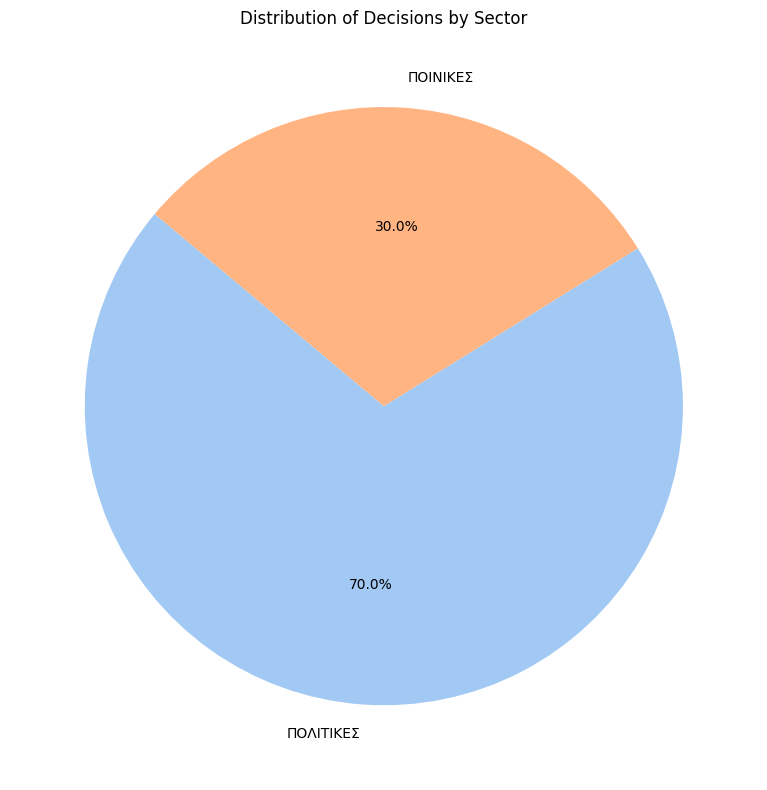


--- Generating Plot 1b: Distribution by Subsector (Top N) ---


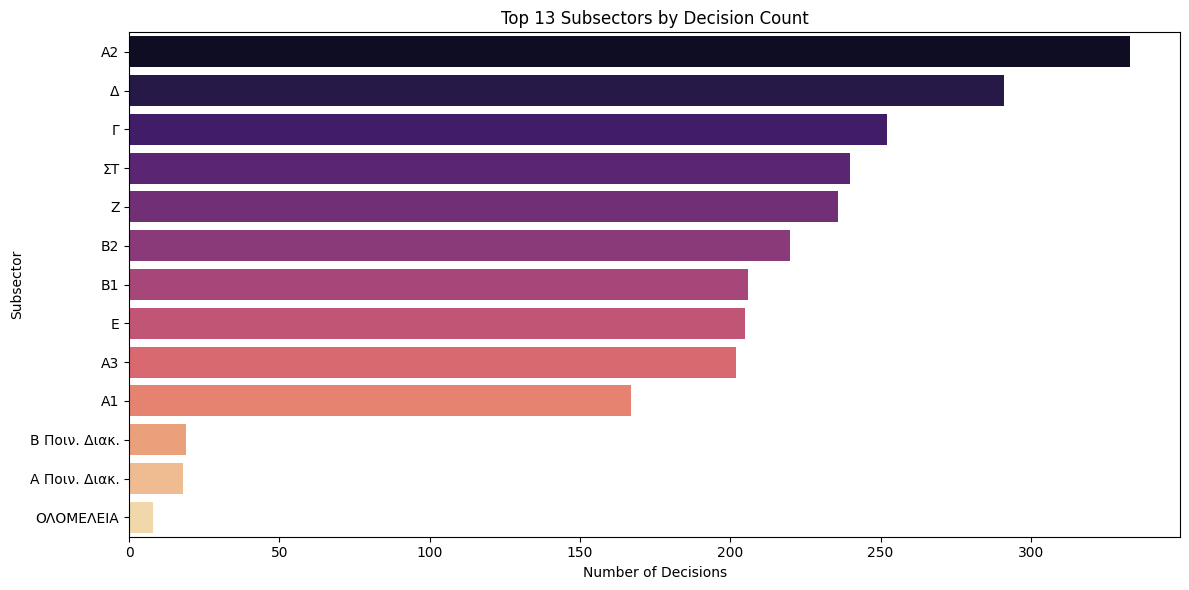

In [53]:
print("\n--- Generating Plot 1a: Distribution by Sector ---")
if 'sector' in df.columns and df['sector'].nunique() > 1:
    plt.figure(figsize=(8, 8))
    sector_counts = df['sector'].value_counts()
    plt.pie(sector_counts, labels=sector_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Distribution of Decisions by Sector')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Sector pie chart (only one sector or column missing).")

print("\n--- Generating Plot 1b: Distribution by Subsector (Top N) ---")
if 'subsector' in df.columns:
    plt.figure(figsize=FIG_SIZE)
    # Determine Top N based on available unique values, capped at a reasonable number
    top_n_subsectors = min(df['subsector'].nunique(), 15)
    sns.countplot(data=df, y='subsector', order=df['subsector'].value_counts().iloc[:top_n_subsectors].index, palette='magma')
    plt.title(f'Top {top_n_subsectors} Subsectors by Decision Count')
    plt.xlabel('Number of Decisions')
    plt.ylabel('Subsector')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Subsector plot (column 'subsector' missing).")

### 6.2 Plot 2: Most Frequently Cited Articles

These plots identify the most commonly cited articles for each legal code (AK, KPolD, PK, KPD) found in the dataset.


--- Generating Plot 2: Most Frequently Cited Articles ---

Analyzing articles for Code: AK (Column: articles_ak)


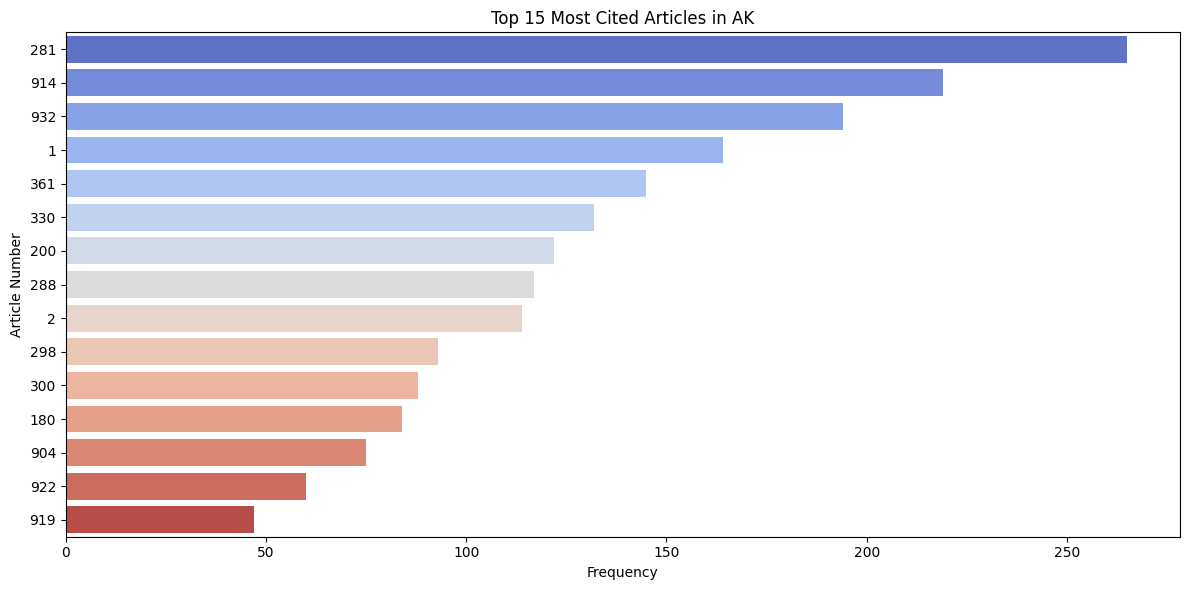


Analyzing articles for Code: KPolΔ (Column: articles_kpolΔ)


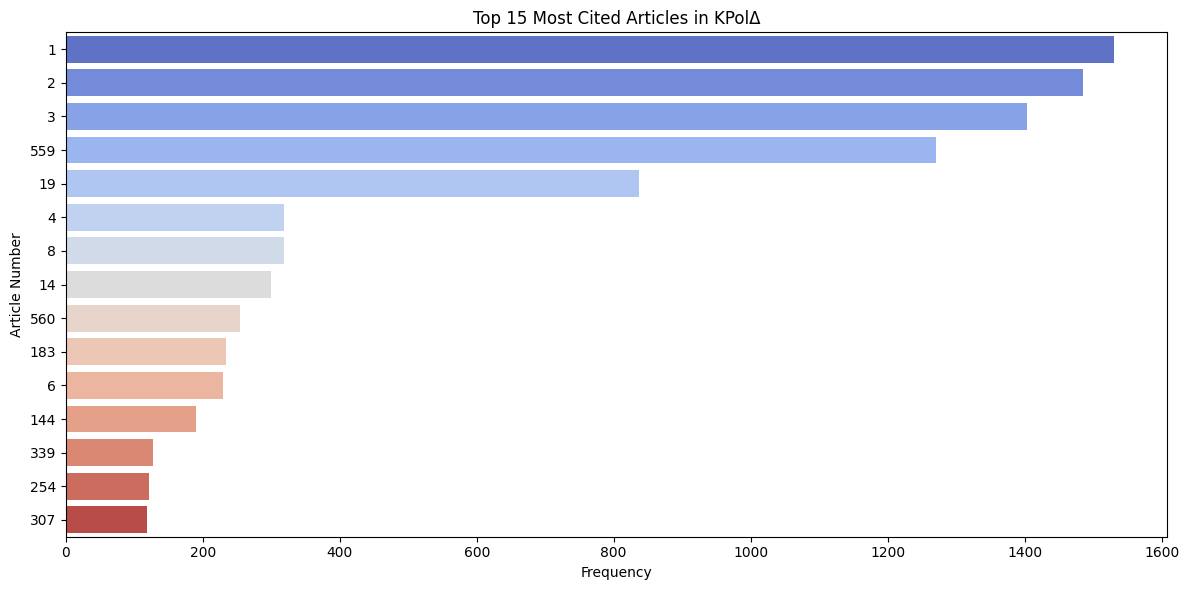


Analyzing articles for Code: PK (Column: articles_pk)


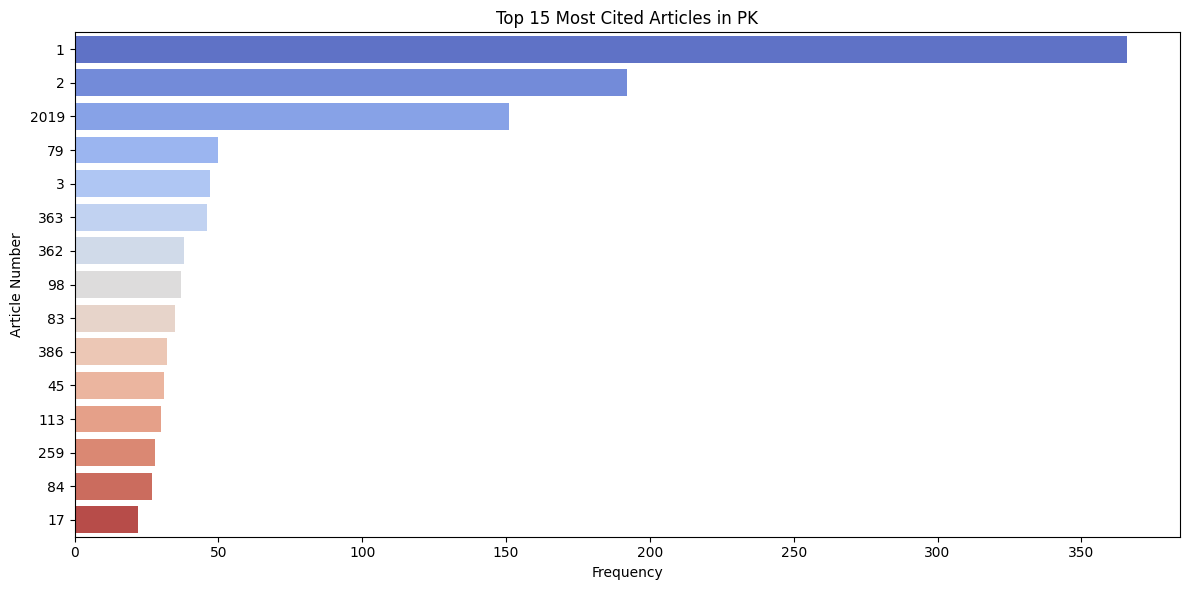


Analyzing articles for Code: KPD (Column: articles_kpd)


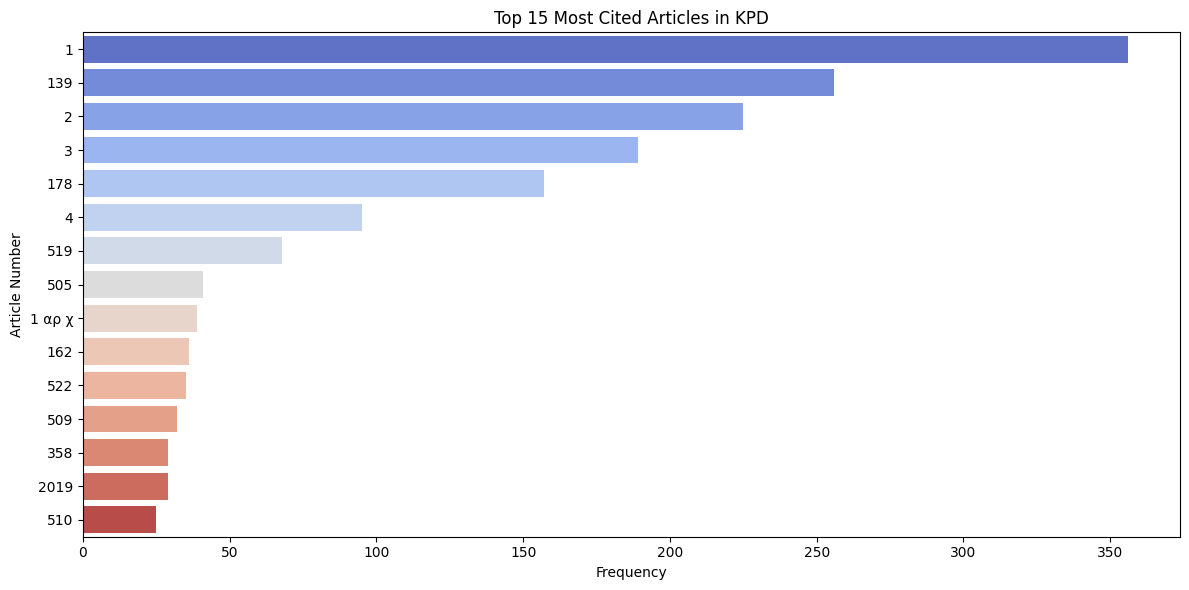

In [54]:
print("\n--- Generating Plot 2: Most Frequently Cited Articles ---")

article_columns = {
    'AK': 'articles_ak',
    'KPolΔ': 'articles_kpolΔ',
    'PK': 'articles_pk',
    'KPD': 'articles_kpd'
}

for code_name, col_name in article_columns.items():
    if col_name in df.columns:
        print(f"\nAnalyzing articles for Code: {code_name} (Column: {col_name})")

        flat_list = [number for sublist in df[col_name] for number in sublist]

        # Count frequencies
        article_counts = Counter(flat_list)
        most_common = article_counts.most_common(TOP_N_ARTICLES)

        if not most_common:
             print(f"No common articles to plot for {code_name}.")
             continue

        # Prepare for plotting
        df_counts = pd.DataFrame(most_common, columns=['Article', 'Frequency'])

        # Plot
        plt.figure(figsize=FIG_SIZE)
        sns.barplot(data=df_counts, x='Frequency', y='Article', palette='coolwarm')
        plt.title(f'Top {len(df_counts)} Most Cited Articles in {code_name}')
        plt.xlabel('Frequency')
        plt.ylabel('Article Number')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col_name}' for code '{code_name}' not found in the dataset.")

### 6.3 Plot 3: Complexity of Decisions

We can estimate the "complexity" of a decision by counting the number of unique articles cited across all relevant legal codes.


--- Generating Plot 3: Complexity of Decisions ---


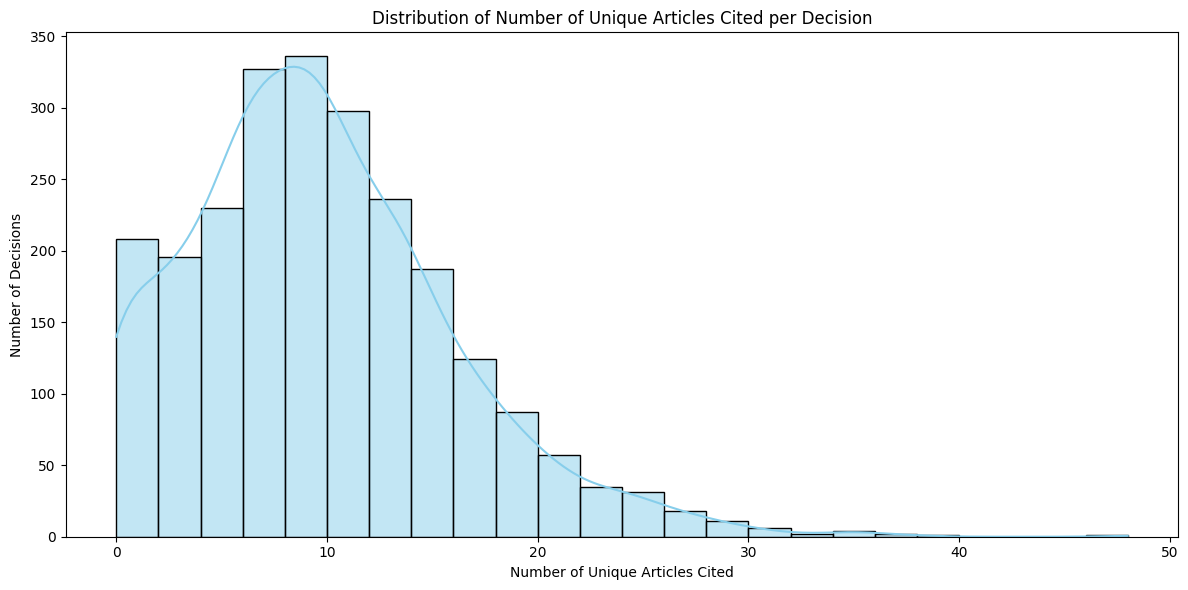

In [55]:
print("\n--- Generating Plot 3: Complexity of Decisions ---")

num_articles_per_decision = []
for row in range(len(df)):
    row_sum = 0
    for article_col in article_columns.values():
        if article_col in df.columns:
            row_sum += len(df[article_col][row])
    num_articles_per_decision.append(row_sum)

# 6a: Histogram of Complexity
plt.figure(figsize=FIG_SIZE)
sns.histplot(num_articles_per_decision, bins=max(1, max(num_articles_per_decision) // 2), kde=True, color='skyblue') # Adjust bins as needed
plt.title('Distribution of Number of Unique Articles Cited per Decision')
plt.xlabel('Number of Unique Articles Cited')
plt.ylabel('Number of Decisions')
plt.tight_layout()
plt.show()

## 7. Conclusion

This notebook demonstrated the process of scraping legal decision data from the Areios Pagos website and performing exploratory data analysis using refined extraction methods. Key insights include trends in decision volume, distribution across sectors, identification of frequently cited articles, and analysis of decision complexity over time. The generated plots provide a visual summary of these findings. Further analysis could involve natural language processing (NLP) on the text fields or more detailed statistical modeling.

In [56]:
print("\n--- Analysis Notebook Complete ---")


--- Analysis Notebook Complete ---
